# Table of Contents
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    * [Data Cleaning](#Data-Cleaning)
    * [Data preprocessing and Analysis](#Data-Visualization-and-Pre-processing)
* [Modeling](#Modeling)
    * [Statistical Machine learning](#Statistical-Machine-Learning)
        * [Training](#Training)
        * [Model Evaluation](#Model-Evaluation)
        * [Model Tuning](#Model-Tuning)
        * [Paremeter Selection](#Paremeter-selection)
        * [Model Comparison](#Model-comparison)
    * [Neural Network](#Neural-Network)
        * [Training and Hypertuning](#Training-and-hypertuning)
        * [Modifying Threshold](#Modifying-threshold)
    * [Trade-off](#Trade-off)
* [Summary](#Summary)
* [References](#References)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, classification_report
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import PowerTransformer, StandardScaler
from imblearn.over_sampling import SMOTE
from IPython.display import display
from sklearn.decomposition import PCA
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
# from functions import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.regularizers import l2
import tensorflow as tf

warnings.filterwarnings('ignore')


random_state = 2
sns.set()

##### Declare needed functions

In [2]:
def confusion_plot(test_data, predicted_data, axis=1):
    """
    Plots confusion matrix graph showing count/values and another graph showing percentage
    
    Parameters
    ----------
        test_data: Actual data
        predicted_data: Predicted data from the model
    """
    # Create confusion matrix on test and predicted data
    conf_mat = confusion_matrix(test_data, predicted_data)
    # Get percentage values
    conf_perc = (conf_mat/conf_mat.sum(axis=axis)) * 100  # axis set to 1 to cover recall rather than precision
    
    # plot heatmap of the confucsion matrix
    sns.heatmap(conf_mat, annot=True, fmt='.1f', cmap='Blues')
    plt.xlabel('predicted data')
    plt.ylabel('actual data')
    plt.title('Confusion matrix (Count)')
    plt.show()   
    
    # plot heatmap of the confusion matrix in percentages
    ax = sns.heatmap(conf_perc, annot=True, fmt='.1f', cmap='Blues')
    for t in ax.texts: t.set_text(t.get_text() + " %")
    plt.xlabel('predicted data')
    plt.ylabel('actual data')
    plt.title('Confusion matrix (Percentage)')
    plt.show()

def train_models(xt, xtt, yt, ytt, model_list):
    """
    
    
    """
    for model in model_list:
        model.fit(xt, yt)
        model_pred = model.predict(xtt)
        if model == xgb:
            print('Model: XGBClassifier')
        else: print(f'Model: {model}')
        print(f"accuracy on train data: {model.score(xt, yt)}")
        print(f"accuracy on test data: {model.score(xtt, ytt)}")
        print(f'f1 score: {f1_score(ytt, model_pred)}')
        print(f'matthews coef score: {matthews_corrcoef(ytt, model_pred)}\n')
    
def feature_imp(x, y, model):
    """
    Displays the influence of attributes on the model's decision making
    
    Parameters
    ----------
        x: independent variables
        y: dependent/predicting variable
        model: classification model
    
    Returns
    -------
        
    """
    perm = PermutationImportance(model).fit(x, y)
    return eli5.show_weights(perm, feature_names = x.columns.tolist())

def corr_plot(columns, df, plt_=None, plt_title=''):
    """
    """
    # Calculate the correlation matrix for target relevant features
    new_corr = df[columns].corr()
    if plt_:
        plt.figure(figsize=plt_)
    # Visualize the correlation matrix
    sns.heatmap(new_corr, annot=True, cmap='Blues')
    plt.title(plt_title)
    plt.show()
    
def pca(data, count):
    pca = PCA(n_components=count).fit_transform(data)
    return pca

def nn_model(blocks=[], dropout=0, regu=0.01, final=1, activation='sigmoid', first=32):
    """"""
    model = Sequential()
    model.add(Dense(first, activation='relu', input_dim=norm_d.shape[1]))
    for i in blocks:
        model.add(Dense(i, activation='relu', kernel_regularizer=l2(regu)))
        model.add(Dropout(dropout))
    model.add(Dense(final, activation=activation))
    return model

def nn_compile(loss='binary_crossentropy',
               optimizer='adam',
               epochs=150,
               batch_size=1,
               blocks=[],                
               dropout=0,
               regu=0.01,
               final=1,
               activation='sigmoid', 
               patience=3,
               first=32,
               verbose=0,
               monitor="val_loss"):
    # define and compile neural network model
    _model = nn_model(blocks=blocks, dropout=dropout, regu=regu, final=final, activation=activation, first=first)
    _model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    # set callback clause/method
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience)]
    # train the model
    hist = _model.fit(norm_d.values,
                      y_t.values, 
                      callbacks=callbacks,
                      validation_data=(norm_val, y_val),
                      epochs=epochs, 
                      batch_size=batch_size,
                      verbose=verbose)
    return hist.history, _model

def nn_evaluation(model, sparse=False):
    # get predictions on training, validation, and test data
    pred = model.predict(norm_d, verbose=0)
    vpred = model.predict(norm_val, verbose=0)
    tpred = model.predict(norm_test, verbose=0)
    
    # convert the neural network predictions to a binary format (0 or 1)
    if sparse:
        pred = prd(pred)
        vpred = prd(vpred)
        tpred = prd(tpred)
    else:
        pred = [round(predictions[0]) for predictions in pred]
        vpred = [round(predictions[0]) for predictions in vpred]
        tpred = [round(predictions[0]) for predictions in tpred]
        
    # Evaluate the model's predictions
    print('Training accuracy')
    print(f'f1 score: {f1_score(y_t, pred)}')
    print(f'matthews coef score: {matthews_corrcoef(y_t, pred)}\n')
    
    print('Validation accuracy')
    print(f'f1 score: {f1_score(y_val, vpred)}')
    print(f'matthews coef score: {matthews_corrcoef(y_val, vpred)}\n')
    
    print('Test accuracy')
    print(f'f1 score: {f1_score(y_test, tpred)}')
    print(f'matthews coef score: {matthews_corrcoef(y_test, tpred)}\n')

def prd(pred):
    """
    Converts sparse predictions(list of lists) to binary format (list of 0s or 1s as elements)
    :param pred: model predictions :type: list
    :return new_pred: list of predictions as numbers for easy interpretation :type: list
    """
    new_pred = []
    for i in pred:
        i = np.round(i, 5)
        for ii_index, ii in enumerate(list(i)):
            if ii == max(i):
                new_pred.append(ii_index)
    return new_pred

def prd2(pred, threshold):
    new_pred = []
    for i in pred:
        i = np.round(i, 5)
        if i[0] < threshold:
            new_pred.append(1)
        else:
            new_pred.append(0)
    return new_pred

def classification_rep(model, x_Test, y_Test, plot=False, return_=False):
    pred = model.predict(x_Test)
    print(classification_report(y_Test, pred))
    if plot:
        confusion_plot(y_Test, pred)
    if return_:
        return pred

In [3]:
df = pd.read_csv('breast_cancer_data.csv')
# Let's view our data
df.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

# Exploratory Data Analysis
___

## Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

### Observation:
* `All independent variables are of type float (numbers). This determines the approach to take in the data preprocessing stage`<p></p>
* `There is an irrelevant column (Unnamed: 32) with no data point`<p></p>
* `Inconsistency in column naming. Some column names have white spaces (naming inconsistency).`

In [5]:
df.describe(include='all')

id diagnosis  radius_mean  texture_mean  perimeter_mean  \
count   5.690000e+02       569   569.000000    569.000000      569.000000   
unique           NaN         2          NaN           NaN             NaN   
top              NaN         B          NaN           NaN             NaN   
freq             NaN       357          NaN           NaN             NaN   
mean    3.037183e+07       NaN    14.127292     19.289649       91.969033   
std     1.250206e+08       NaN     3.524049      4.301036       24.298981   
min     8.670000e+03       NaN     6.981000      9.710000       43.790000   
25%     8.692180e+05       NaN    11.700000     16.170000       75.170000   
50%     9.060240e+05       NaN    13.370000     18.840000       86.240000   
75%     8.813129e+06       NaN    15.780000     21.800000      104.100000   
max     9.113205e+08       NaN    28.110000     39.280000      188.500000   

          area_mean  smoothness_mean  compactness_mean  concavity_mean  \
count    569.000000       569.000000        569.000000      569.000000   
unique          NaN              NaN               NaN             NaN   
top             NaN              NaN               NaN             NaN   
freq            NaN              NaN               NaN             NaN   
mean     654.889104         0.096360          0.104341        0.088799   
std      351.914129         0.014064          0.052813        0.079720   
min      143.500000         0.052630          0.019380        0.000000   
25%      420.300000         0.086370          0.064920        0.029560   
50%      551.100000         0.095870          0.092630        0.061540   
75%      782.700000         0.105300          0.130400        0.130700   
max     2501.000000         0.163400          0.345400        0.426800   

        concave points_mean  ...  texture_worst  perimeter_worst   area_worst  \
count            569.000000  ...     569.000000       569.000000   569.000000   
unique                  NaN  ...            NaN              NaN          NaN   
top                     NaN  ...            NaN              NaN          NaN   
freq                    NaN  ...            NaN              NaN          NaN   
mean               0.048919  ...      25.677223       107.261213   880.583128   
std                0.038803  ...       6.146258        33.602542   569.356993   
min                0.000000  ...      12.020000        50.410000   185.200000   
25%                0.020310  ...      21.080000        84.110000   515.300000   
50%                0.033500  ...      25.410000        97.660000   686.500000   
75%                0.074000  ...      29.720000       125.400000  1084.000000   
max                0.201200  ...      49.540000       251.200000  4254.000000   

        smoothness_worst  compactness_worst  concavity_worst  \
count         569.000000         569.000000       569.000000   
unique               NaN                NaN              NaN   
top                  NaN                NaN              NaN   
freq                 NaN                NaN              NaN   
mean            0.132369           0.254265         0.272188   
std             0.022832           0.157336         0.208624   
min             0.071170           0.027290         0.000000   
25%             0.116600           0.147200         0.114500   
50%             0.131300           0.211900         0.226700   
75%             0.146000           0.339100         0.382900   
max             0.222600           1.058000         1.252000   

        concave points_worst  symmetry_worst  fractal_dimension_worst  \
count             569.000000      569.000000               569.000000   
unique                   NaN             NaN                      NaN   
top                      NaN             NaN                      NaN   
freq                     NaN             NaN                      NaN   
mean                0.114606        0.290076                 0.083946   
std                 0.06

For better coding practice, let us replace space with underscores in the columns

In [6]:
df = df.rename(columns=lambda x: x.replace(' ', '_'))

In [7]:
# convert target variable to binary
df.diagnosis = df.diagnosis.map({'B': 0, 'M': 1})

In [8]:
# check for duplicates in the data
df.id.duplicated().sum()

0

`Id is useful to spot duplicates, however, since there are no duplicates, we can drop the column alongside irrelevant columns.`

In [9]:
df.drop(columns=['id', 'Unnamed:_32'], inplace=True)

`The data does not have 'NaN' values however, for numerical columns, 0 may be an indicator of missing values. Let's check for columns that have zero as their minimum and then check the value counts`

In [10]:
missing_col = []
# loop through columns of dataframe identify columns which have 0 as minimum
for i in df.columns:
    if df[i].min() <= 0:
        print(i)
        missing_col.append(i)
# remove diagnosis column which has binary values (0 and 1)
missing_col.remove('diagnosis')

diagnosis
concavity_mean
concave_points_mean
concavity_se
concave_points_se
concavity_worst
concave_points_worst


`Now let's show the value counts for these columns`

In [11]:
df[missing_col].value_counts().head()

concavity_mean  concave_points_mean  concavity_se  concave_points_se  concavity_worst  concave_points_worst
0.0000          0.00000              0.00000       0.000000           0.0000           0.00000                 13
0.1065          0.06021              0.05101       0.022950           0.2216           0.11050                  1
0.1030          0.04391              0.06271       0.019660           0.2388           0.09265                  1
0.1036          0.07488              0.02713       0.013450           0.3508           0.19390                  1
0.1043          0.05613              0.02219       0.009231           0.2992           0.13120                  1
dtype: int64

`For better visualization/understanding:`

In [12]:
for i in missing_col:
    display(df[i].value_counts().head())

0.00000    13
0.12040     3
0.11150     2
0.03344     2
0.11030     2
Name: concavity_mean, dtype: int64

0.00000    13
0.02864     3
0.14710     2
0.05778     2
0.02272     2
Name: concave_points_mean, dtype: int64

0.00000    13
0.01652     2
0.01698     2
0.02681     2
0.03576     2
Name: concavity_se, dtype: int64

0.00000    13
0.01167     3
0.01110     3
0.01499     3
0.01004     2
Name: concave_points_se, dtype: int64

0.0000    13
0.4504     3
0.1377     3
0.1804     2
0.1811     2
Name: concavity_worst, dtype: int64

0.00000    13
0.05556     3
0.06296     3
0.12180     3
0.07431     3
Name: concave_points_worst, dtype: int64

### Observation:
* `We can see that for all these columns, zero might be a missing value.`

* `All the columns have the word concave and they have the same number of missing values. We may suspect correlation`

### Next steps:
* `First we replace missing values with mean`

* `Before we begin any experimental changes to our data, we create a copy of the dataframe`

In [13]:
df2 = df.copy()

# loop through columns with missing values and replace missing values with mean
for i in missing_col:
    mean = df2[i].mean()
    df2[i] = df2[i].replace(0, mean)
df2[missing_col].value_counts().head()

concavity_mean  concave_points_mean  concavity_se  concave_points_se  concavity_worst  concave_points_worst
0.088799        0.048919             0.031894      0.011796           0.272188         0.114606                13
0.000692        0.004167             0.000692      0.004167           0.001845         0.011110                 1
0.102000        0.055640             0.049610      0.018410           0.318600         0.141600                 1
0.103000        0.043910             0.062710      0.019660           0.238800         0.092650                 1
0.103600        0.074880             0.027130      0.013450           0.350800         0.193900                 1
dtype: int64

## Data Visualization and Pre-processing

Let's check the distribution of classes

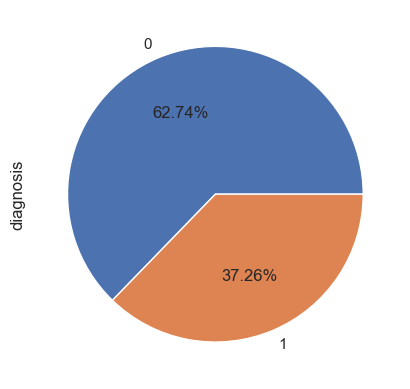

In [14]:
df.diagnosis.value_counts().plot.pie(autopct='%1.2f%%');

### Observation:
* `Imbalanced dataset`

### Next steps:
* `Split the data into training and testing sets`

* `Balance the data`
* `Scale the data`

In [15]:
# get the independent variables
indep_var = df2.drop(['diagnosis'], axis=1)
# get the target variable
dep_var = df2['diagnosis']

# split the data
x_train, x_test, y_train, y_test = train_test_split(indep_var, dep_var, test_size=0.3, random_state=random_state)
# apply smote balancing to the training set
smote_algo = SMOTE(random_state=random_state)
smote_data_X, smote_data_Y = smote_algo.fit_resample(x_train, y_train)

In [16]:
# Scale the training and test independent variables
sc = StandardScaler()
smote_data = sc.fit_transform(smote_data_X)
smote_test = sc.transform(x_test)
smote_data = pd.DataFrame(smote_data, columns=x_train.columns)
smote_test = pd.DataFrame(smote_test, columns=x_test.columns)

`There are more pre-processing to do , however, we want to test the performance of the balanced and scaled data later on. So we will create a copy of the dataset before we go ahead with other data pre-processing steps`

In [17]:
df3 = smote_data.copy()
df_test = smote_test.copy()

### Systematically Reduced Dataset

`Remember our suspicion about the columns with the word 'concave' being correlated?`

`We will use the correlation matrix to check for this`

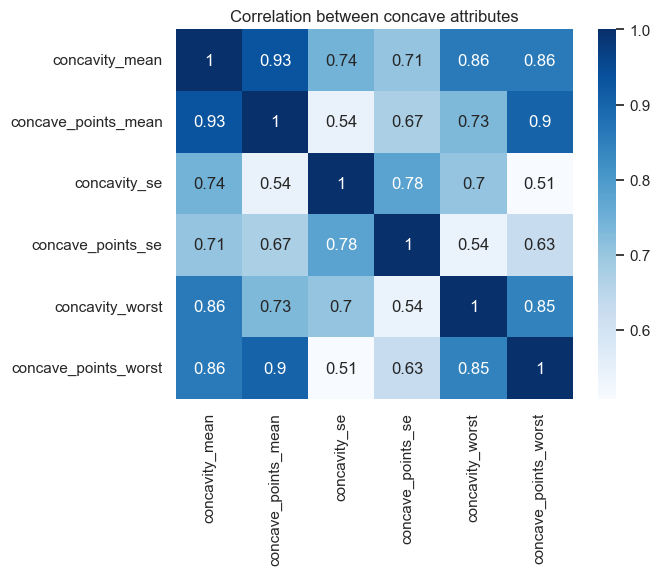

In [18]:
# Checking correlation between subset of variables
corr_plot(missing_col, df3, 
          plt_title='Correlation between concave attributes')

### Observation:
* `We can see some correlation between the attributes`
### Next:
* `Let's use pca to create a new attribute that best represents all these attributes`

In [19]:
# get an attribute that best represents all attributes using PCA
concave_features = pca(df3[missing_col], 1)
# do the same for the test data
concave_features_test = pca(df_test[missing_col], 1)
# drop the old/previous attributes from the data
df3.drop(columns=missing_col, inplace=True)
df_test.drop(columns=missing_col, inplace=True)
# store new attribute in the dataframe
df3['concave'] = concave_features
df_test['concave'] = concave_features_test

`As seen in the case of "concave" above, there are other attributes with similar words which may be highly correlated.`

`Let's find these similarly worded attributes and check the correlation with each set`

In [20]:
# list to hold repeated words in columns
repititive_list = []

# loop through columns and get repeated words (view output of cell below to understand approach)
# Loop through columns
for i in df3.columns:
    # identify columns that have the word 'mean'
    if 'mean' in i:
        # get the column name but remove the word 'mean'
        repititive_list.append(i.replace('_mean', ''))
# store the data as dictionary of strings (keys) to lists (values)
repititive_dict = {}
for i in repititive_list:
    repititive_dict[i] = []
repititive_dict

{'radius': [],
 'texture': [],
 'perimeter': [],
 'area': [],
 'smoothness': [],
 'compactness': [],
 'symmetry': [],
 'fractal_dimension': []}

`Now we group similarly worded column names in lists`

In [21]:
repititive_dict = {key: [col for col in df3.columns if key in col] for key, val in repititive_dict.items()}
repititive_dict

{'radius': ['radius_mean', 'radius_se', 'radius_worst'],
 'texture': ['texture_mean', 'texture_se', 'texture_worst'],
 'perimeter': ['perimeter_mean', 'perimeter_se', 'perimeter_worst'],
 'area': ['area_mean', 'area_se', 'area_worst'],
 'smoothness': ['smoothness_mean', 'smoothness_se', 'smoothness_worst'],
 'compactness': ['compactness_mean', 'compactness_se', 'compactness_worst'],
 'symmetry': ['symmetry_mean', 'symmetry_se', 'symmetry_worst'],
 'fractal_dimension': ['fractal_dimension_mean',
  'fractal_dimension_se',
  'fractal_dimension_worst']}

### Plot the correlation of each group/set

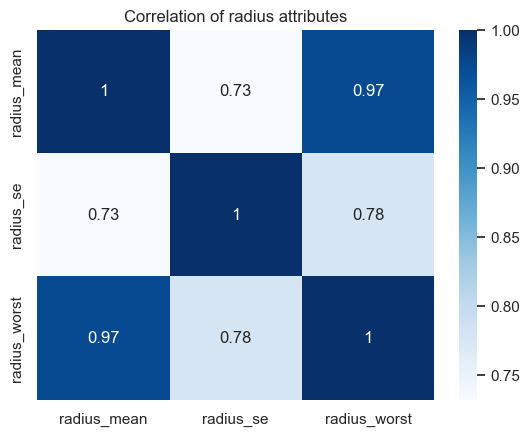

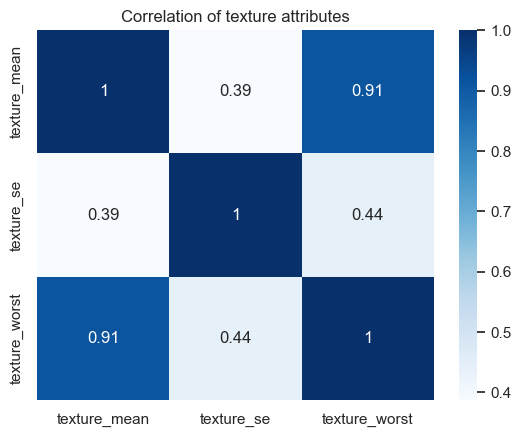

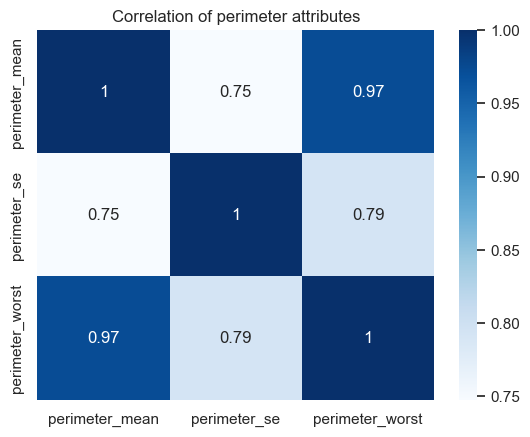

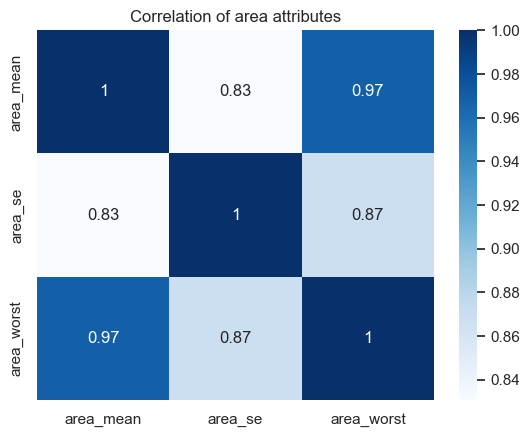

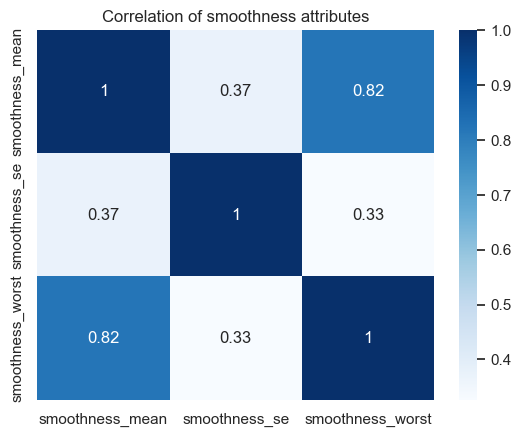

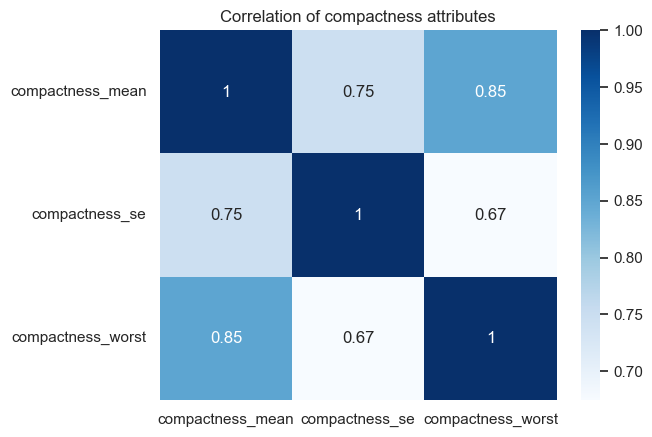

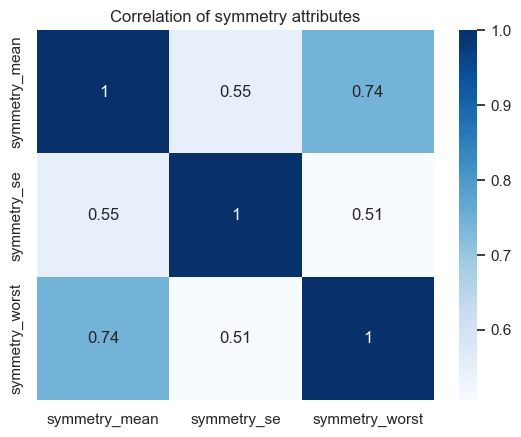

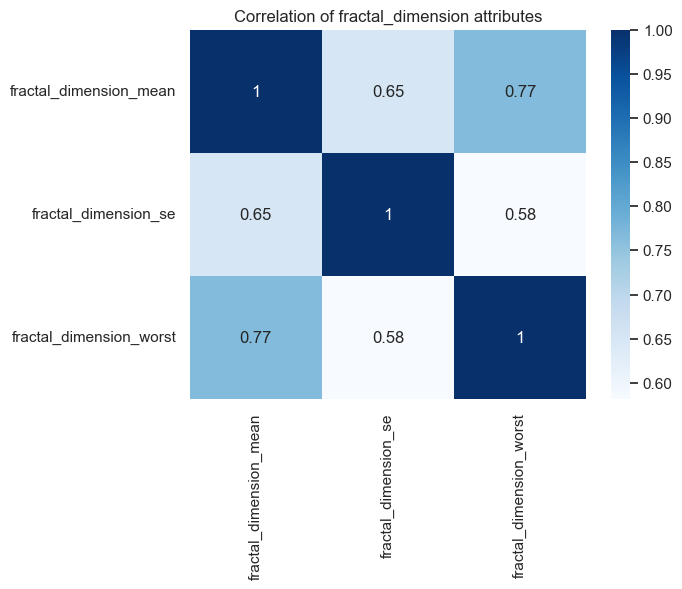

In [22]:
for key, val in repititive_dict.items():
    corr_plot(val, df3, plt_title=f"Correlation of {key} attributes")

### Observation:
* `We see a high correlation in each set. Particularly with attributes which have the word "mean" and "worst".`

### Next
* `We will use pca to create a column that best represents each set`

In [23]:
for key, val in repititive_dict.items():
    # val here is a list of column names
    # get an attribute that best represents all columns in list
    features = pca(df3[val], 1)
    # do the same for test
    feat_test = pca(df_test[val], 1)
    # replace the columns with the pca attribute
    df3.drop(columns=val, inplace=True)
    df_test.drop(columns=val, inplace=True)
    df3[key] = features
    df_test[key] = feat_test

In [24]:
df3.head()

concave    radius   texture  perimeter      area  smoothness  compactness  \
0 -2.677859 -1.846387 -3.814731  -1.894889 -1.568569    0.304693    -1.708074   
1 -1.298818 -1.089211 -2.534567  -0.953144 -1.001184   -1.497738    -0.536432   
2  0.395003 -0.636709  0.379169  -0.361189 -0.644393   -1.843936     0.941333   
3  1.326865  1.402736  1.362269   1.178151  1.407947    1.450041    -0.745166   
4 -3.656427 -1.546334 -1.448351  -1.571842 -1.387972   -1.341963    -2.033953   

   symmetry  fractal_dimension  
0 -2.337231          -0.568098  
1 -1.071427          -1.265641  
2 -1.792165          -0.161361  
3 -1.285834          -2.012322  
4 -0.507176          -0.951209

Going forward, we will refer to this dataset as the systematically reduced dataset

In [25]:
df3['diagnosis'] = smote_data_Y

`Let's check the distribution of our systematically reduced dataset and the relationship between dependent and independent attributes`

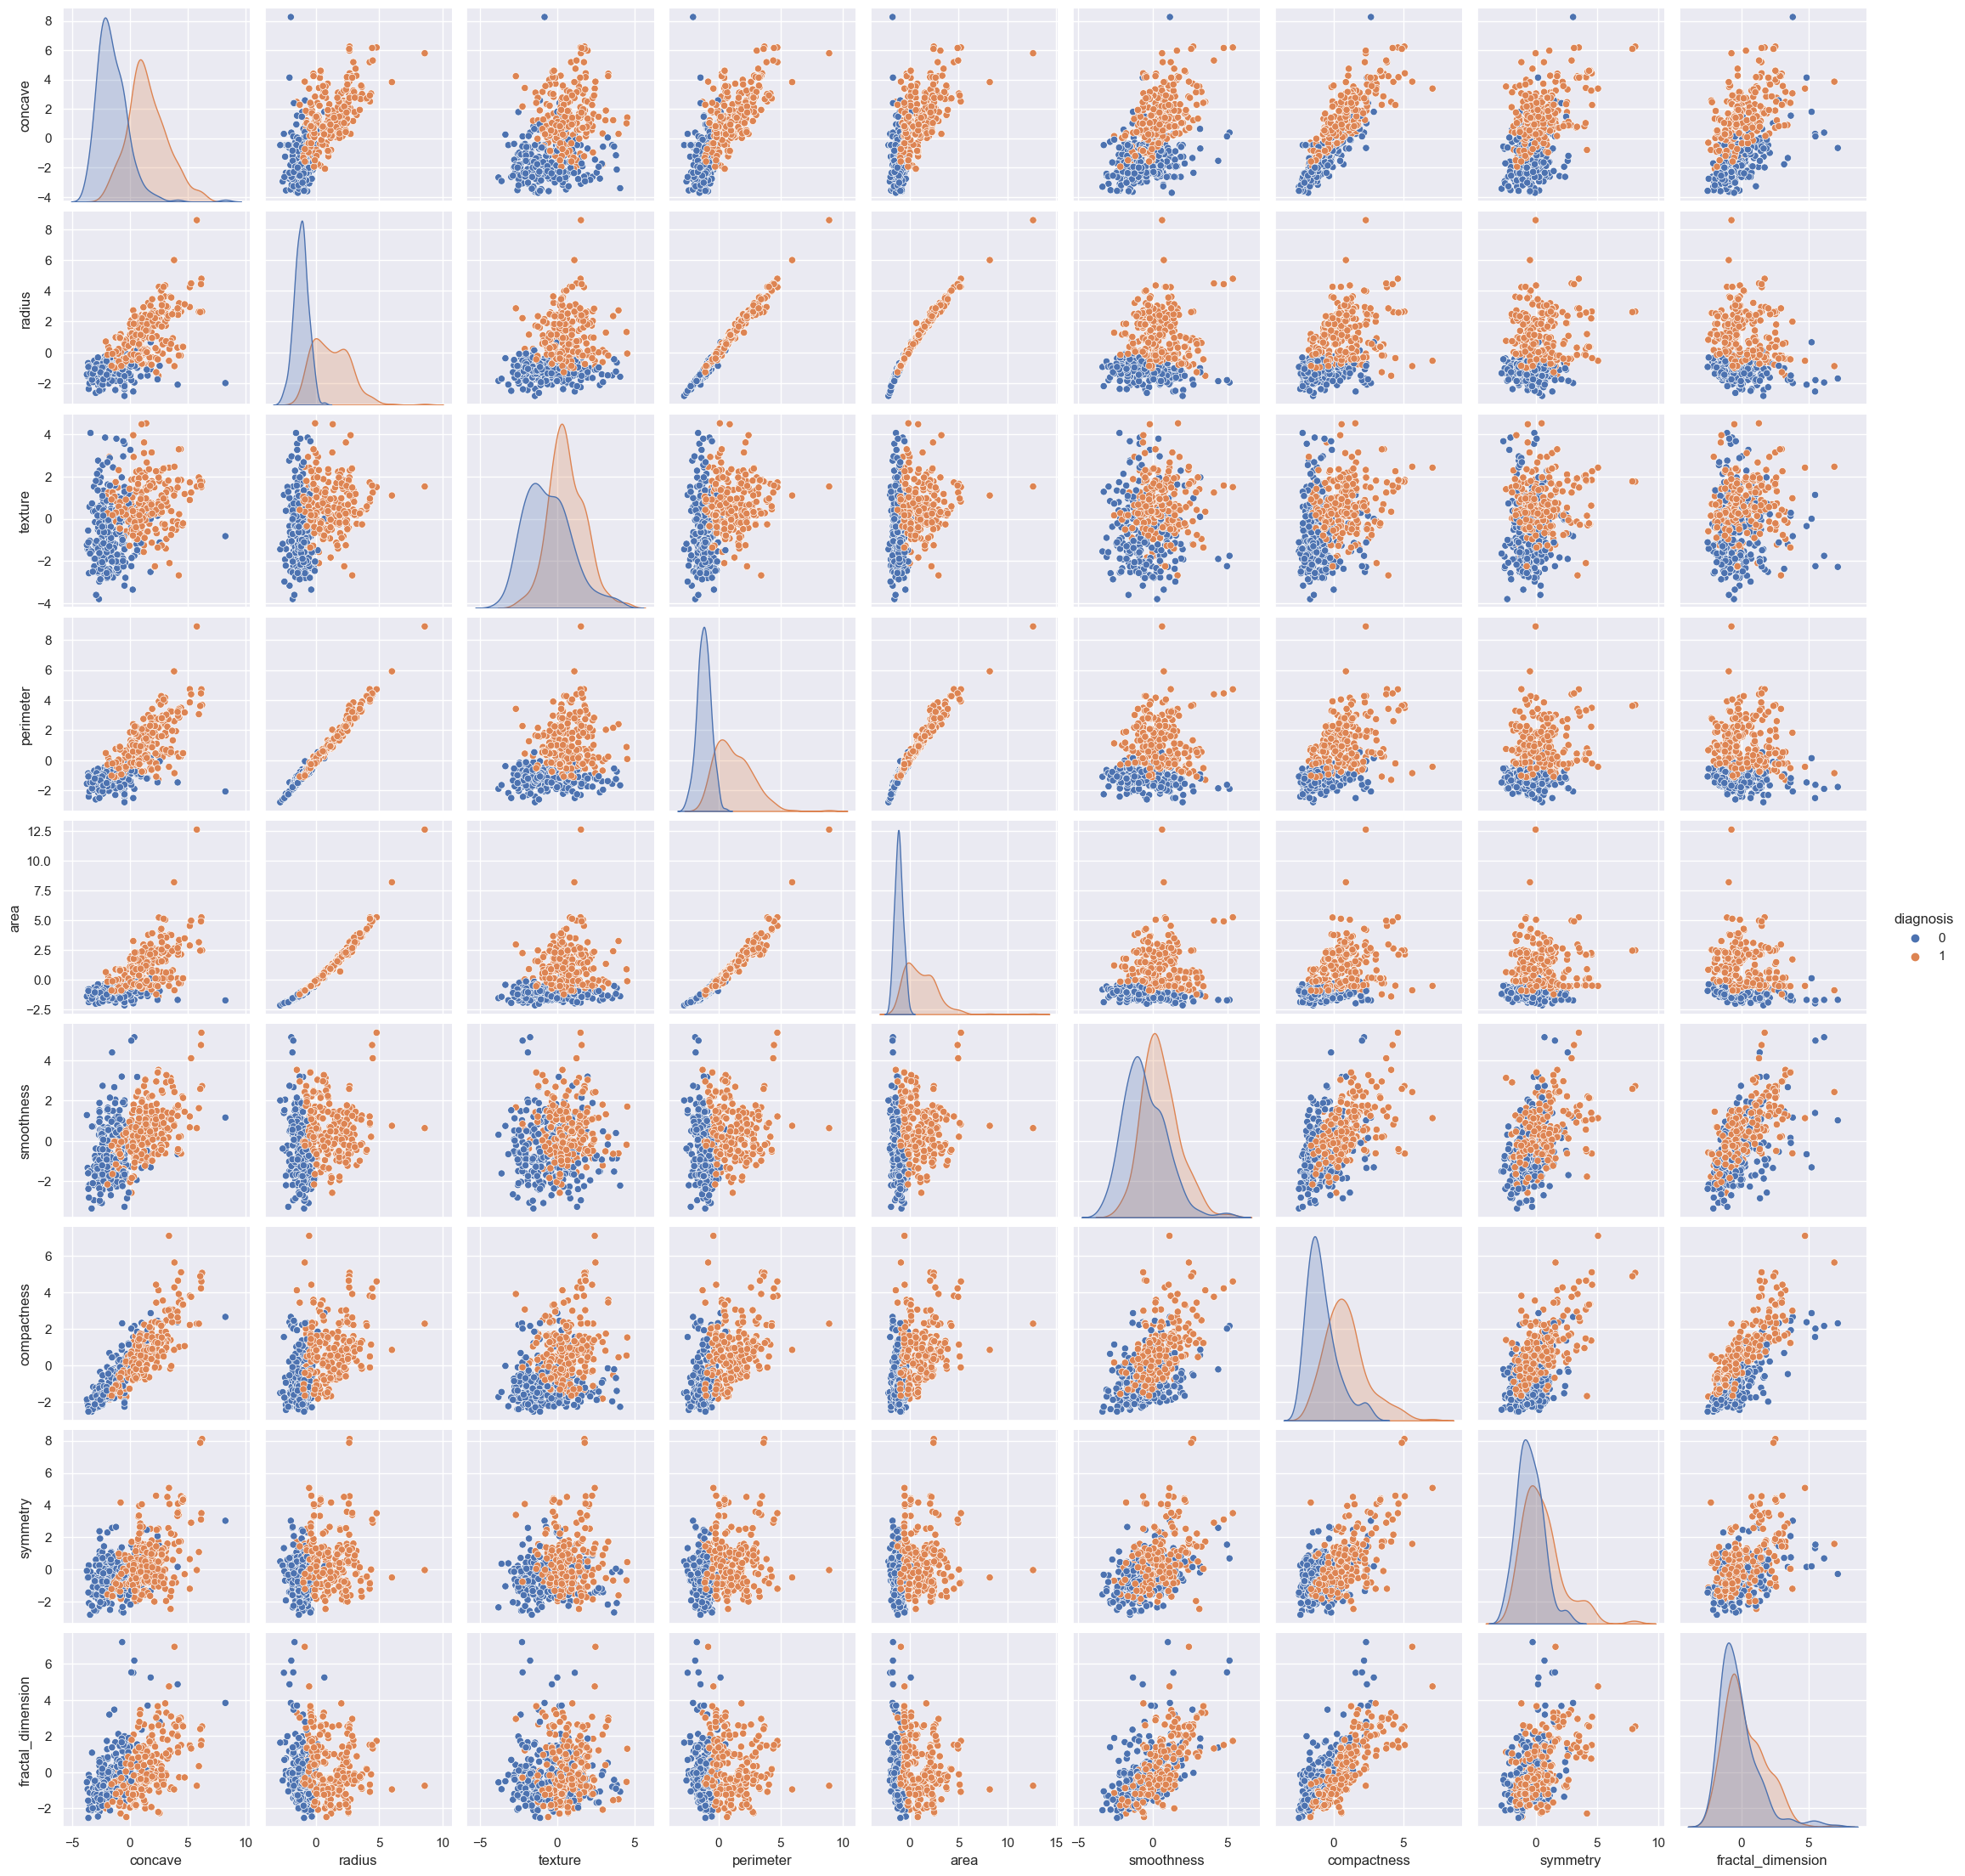

In [26]:
sns.pairplot(df3, hue='diagnosis')
plt.show()

### Observation:
* <h5>Correlation</h5>

    * `We can see high linear correlation between some independent attributes`
    
    * `We can see some scatter plots have a linear relationship with the target attribute.`
* <h5>Distribution</h5>

    * `Some attributes have a skewed distribution and some have a normal distribution`

### Next:
* `We can explore the relationship between the highly/linearly correlated independent attributes and the target variable`

In [27]:
df3[['radius', 'area', 'perimeter', 'diagnosis']].corr()

radius      area  perimeter  diagnosis
radius     1.000000  0.984353   0.992487   0.733266
area       0.984353  1.000000   0.977385   0.677740
perimeter  0.992487  0.977385   1.000000   0.733868
diagnosis  0.733266  0.677740   0.733868   1.000000

### Observation:
* <code>We see that these selected independent variables are highly correlated.</code>

### Next
* <code>We may choose to remove two out of the three selected independent attributes, or create a new attribute that represents all three attributes using pca</code>

In [28]:
df3.drop(columns='diagnosis', inplace=True)
# Removing two of the three attributes
df4 = df3.copy()
df4_test = df_test.copy()
df3.drop(columns=['radius','area'], inplace=True)
df_test.drop(columns=['radius','area'], inplace=True)

In [29]:
# creating a new attribute that represents the three independent variables
measurement_features = pca(df4[['radius', 'area', 'perimeter']], 1)
measurement_features_test = pca(df4_test[['radius', 'area', 'perimeter']], 1)
df4.drop(columns = ['radius', 'area', 'perimeter'], inplace=True)
df4['measurements'] = measurement_features
df4_test.drop(columns = ['radius', 'area', 'perimeter'], inplace=True)
df4_test['measurements'] = measurement_features_test

### Next:
* `Let's investigate the distribution of each attribute`

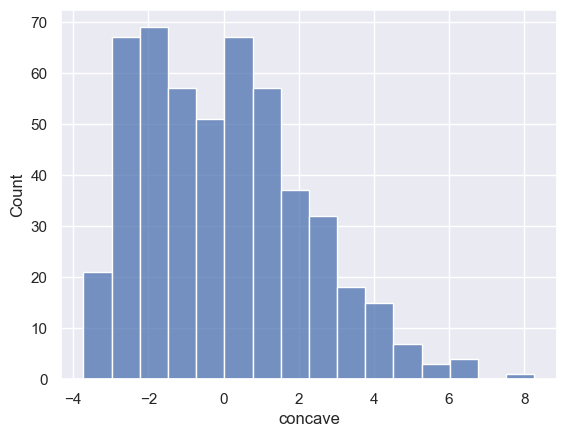

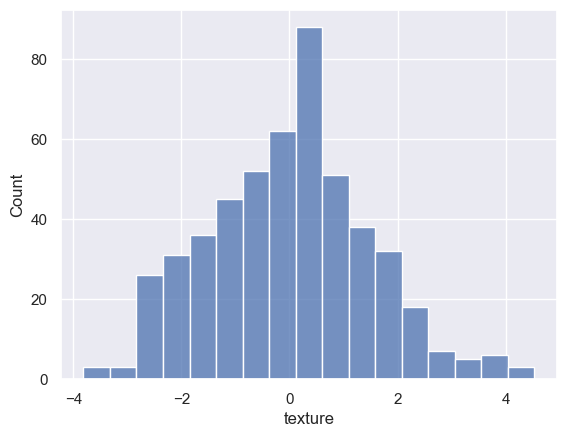

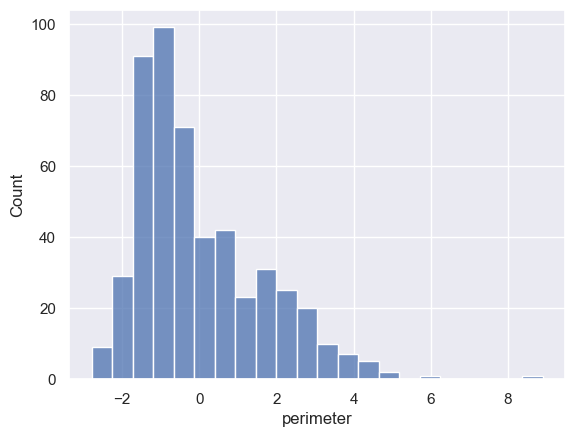

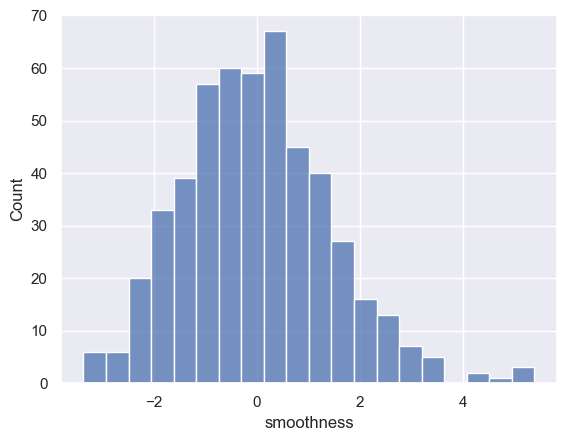

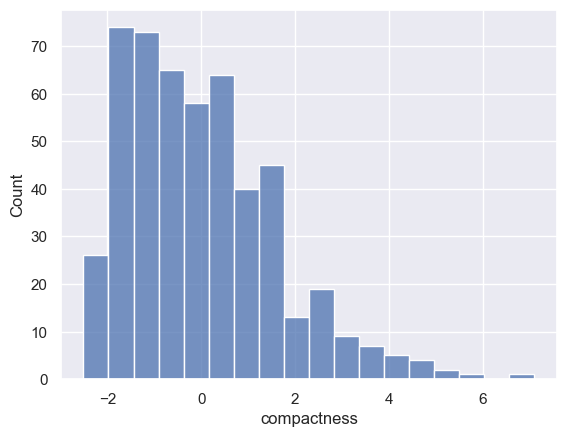

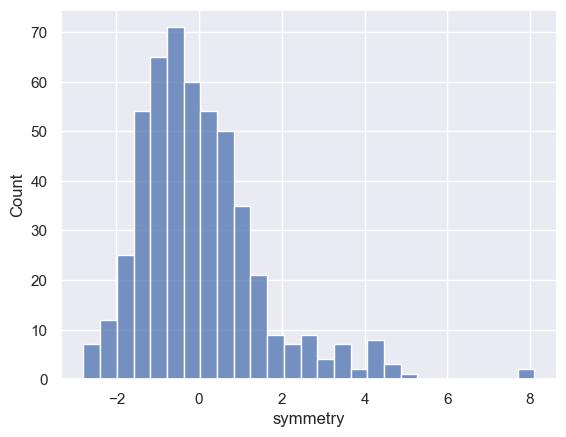

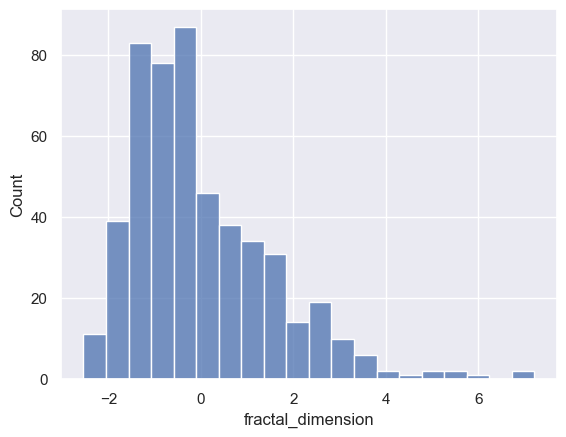

In [30]:
for i in df3.columns:
    sns.histplot(df3[i])
    plt.show()

### Observation:
* `Some attributes are skewed. We may need to apply log or some function to these attributes to normalize the distribution in an attempt to increase model performance`

### Final correlation matrix of our systematically reduced dataset

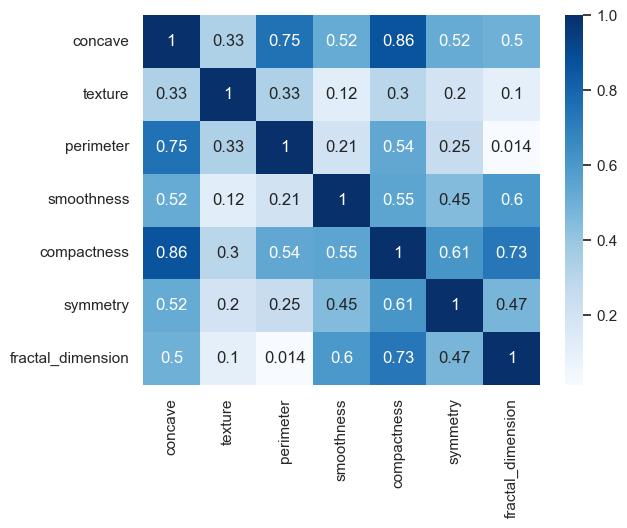

In [31]:
corr_plot(df3.columns, df3)

### Observation:
* `There isn't as much correlation between attributes as compared to the original data below`

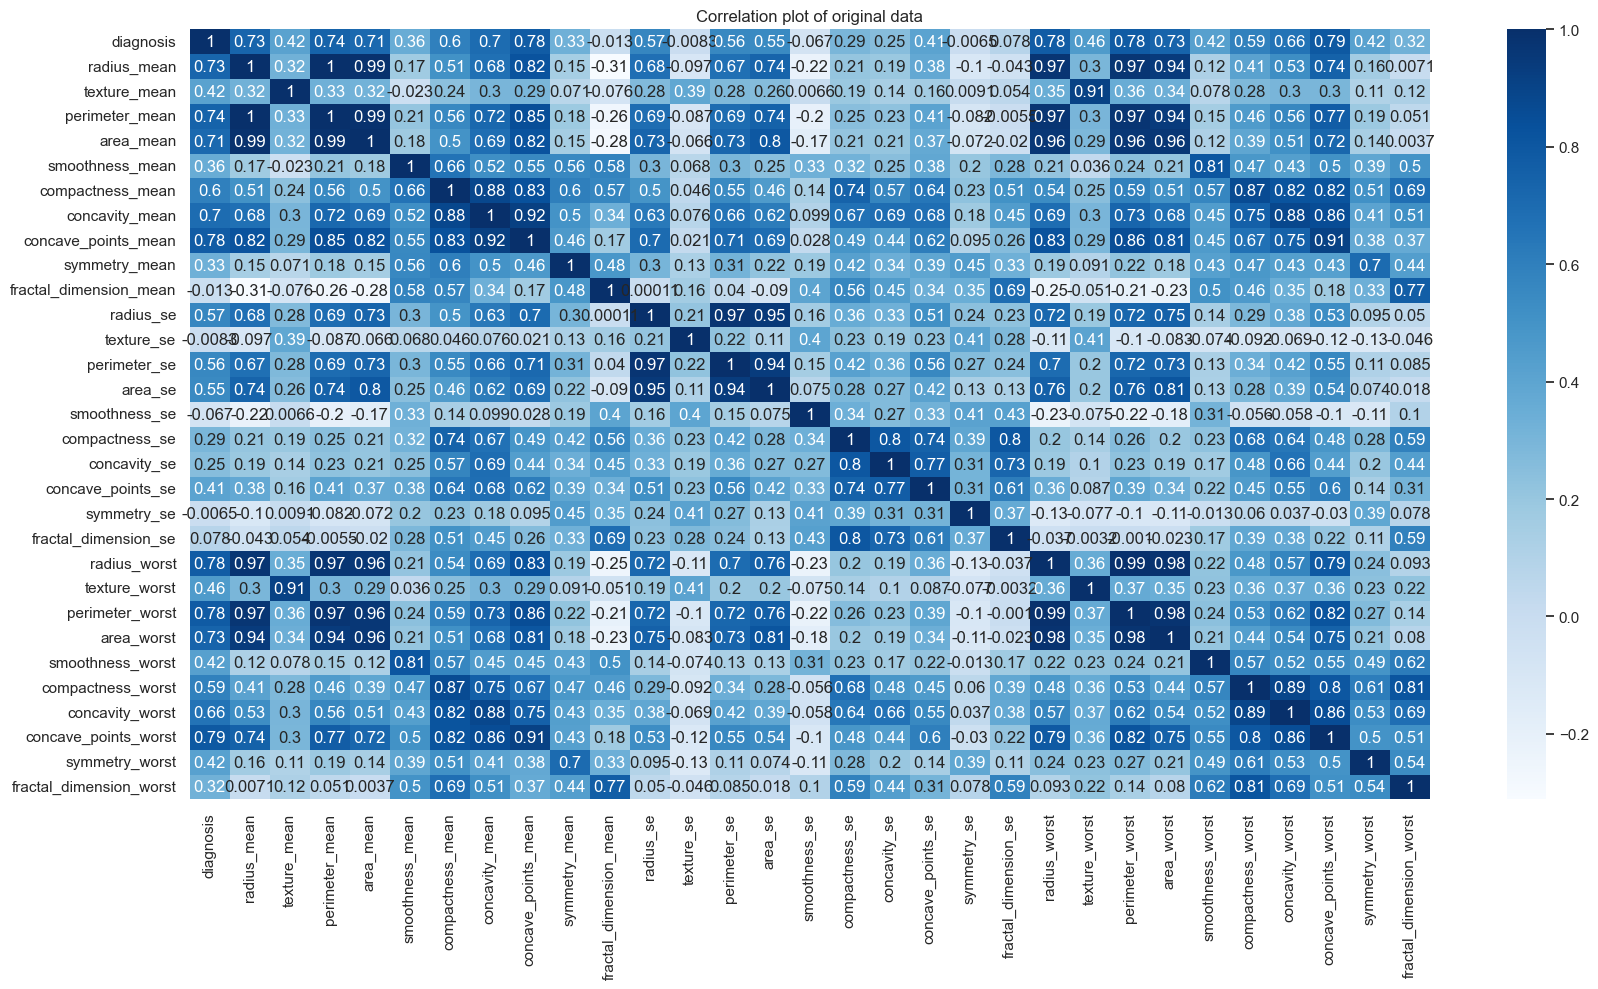

In [32]:
corr_plot(df.columns, df, plt_=[20,10], plt_title='Correlation plot of original data')

## Straight-forward PCA approach

`We are done with systematically reducing the dataset. Now we will use the straight-forward PCA approach and compare performance later on.`


`For this approach, we need to determine a good number of attibutes to reduce the dataset to.`

`We will do this using the elbow method`

In [33]:
pca_ = PCA()
pca_.fit(smote_data)
# print the first 5 pca components
pca_.explained_variance_ratio_[:5]

array([0.46444424, 0.18674513, 0.09224257, 0.06433399, 0.04665856])

`We see that the first principal component is responsible for 46.44% variance. This means we will need to use more than one pca component`

### Next:
* `Let's determine a good pca component to use using the elbow method`

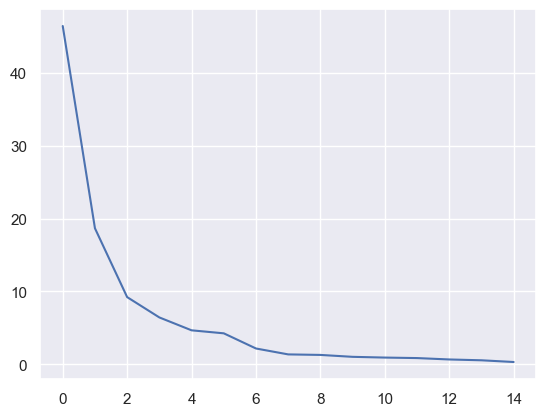

In [34]:
plt.plot(pca_.explained_variance_ratio_[:15] * 100);

### Observation:
* `We see that after the 2nd pca component, the change in variance is low.`

* `We can also see that after the 7th pca component, the change in variance is very low`

### Next:
* `Let's see how much variance the first 2 and 7 components cover respectively`

In [35]:
print(f"2 components: {pca_.explained_variance_ratio_[:2].sum()}")
print(f"7 components: {pca_.explained_variance_ratio_[:7].sum()}")

2 components: 0.6511893754177586
7 components: 0.918659173619669


* `The first 2 pca components cover 65.12% variance. This is a very low number.`<p></p>

* `The first 7 components cover 91.87% variance. This looks like a good number to use. Coincidentally, this is the same number of features we have in our "systematically" reduced dataset`

In [36]:
pca_ = PCA(7)
pca_train = pd.DataFrame(pca_.fit_transform(smote_data))
pca_test = pd.DataFrame(pca_.transform(smote_test))

##  Skeweness

`Remember we observed skewed distribution in the dataset. Here we will use the PowerTransformer function to remove skewness in the original dataset.`

In [37]:
pt=PowerTransformer(method='yeo-johnson') 
norm_dist=pt.fit_transform(x_train)
norm_dist=pd.DataFrame(norm_dist,columns=x_train.columns)
# test
norm_test=pt.fit_transform(x_test)
norm_test=pd.DataFrame(norm_test,columns=x_test.columns)

<hr style="border:2px solid gray">

`Below are the different datasets derived from the data preprocessing stage`

<hr style="border:2px solid gray">

#### Original data
___

In [38]:
df2.head(3)

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38           122.8     1001.0   
1          1        20.57         17.77           132.9     1326.0   
2          1        19.69         21.25           130.0     1203.0   

   smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          17.33            184.6   
1         0.1812  ...         24.99          23.41            158.8   
2         0.2069  ...         23.57          25.53            152.5   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   

   concave_points_worst  symmetry_worst  fractal_dimension_worst  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  

[3 rows x 31 columns]

#### Systematically reduced datasets
___

In [39]:
display(df3.head(3))
df4.head(3)

concave   texture  perimeter  smoothness  compactness  symmetry  \
0 -2.677859 -3.814731  -1.894889    0.304693    -1.708074 -2.337231   
1 -1.298818 -2.534567  -0.953144   -1.497738    -0.536432 -1.071427   
2  0.395003  0.379169  -0.361189   -1.843936     0.941333 -1.792165   

   fractal_dimension  
0          -0.568098  
1          -1.265641  
2          -0.161361

concave   texture  smoothness  compactness  symmetry  fractal_dimension  \
0 -2.677859 -3.814731    0.304693    -1.708074 -2.337231          -0.568098   
1 -1.298818 -2.534567   -1.497738    -0.536432 -1.071427          -1.265641   
2  0.395003  0.379169   -1.843936     0.941333 -1.792165          -0.161361   

   measurements  
0     -3.063652  
1     -1.756961  
2     -0.948973

#### Straight-forward PCA reduced dataset
___

In [40]:
pca_train.head(3)

0         1         2         3         4         5         6
0 -5.279236  0.151702 -0.662440 -3.150279  0.235303 -1.240328 -0.033385
1 -3.187450 -0.814152 -0.955887 -1.585777  1.401136  0.734334 -0.357039
2 -0.824754 -0.266528  0.564288  0.830424  2.913377 -0.111325 -0.541789

#### Balanced dataset with no scaling
___

In [41]:
smote_data_X.head(3)

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        10.80          9.71           68.77      357.6          0.09594   
1        13.28         13.72           85.79      541.8          0.08363   
2        14.59         22.68           96.39      657.1          0.08473   

   compactness_mean  concavity_mean  concave_points_mean  symmetry_mean  \
0           0.05736         0.02531              0.01698         0.1381   
1           0.08575         0.05077              0.02864         0.1617   
2           0.13300         0.10290              0.03736         0.1454   

   fractal_dimension_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0                 0.06400  ...         11.60          12.02            73.66   
1                 0.05594  ...         14.24          17.37            96.59   
2                 0.06147  ...         15.48          27.27           105.90   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0       414.0            0.1436             0.1257           0.1047   
1       623.7            0.1166             0.2685           0.2866   
2       733.5            0.1026             0.3171           0.3662   

   concave_points_worst  symmetry_worst  fractal_dimension_worst  
0               0.04603          0.2090                  0.07699  
1               0.09173          0.2736                  0.07320  
2               0.11050          0.2258                  0.08004  

[3 rows x 30 columns]

#### Normally distributed data
___

In [42]:
norm_dist.head(3)

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0    -1.018999     -2.919612       -1.045201  -1.010619         0.096713   
1    -0.086107     -1.420185       -0.092324  -0.091874        -0.840573   
2     0.318633      0.800916        0.381762   0.316304        -0.751753   

   compactness_mean  concavity_mean  concave_points_mean  symmetry_mean  \
0         -1.010480       -1.018725            -1.018986      -1.831068   
1         -0.188836       -0.403018            -0.462125      -0.677817   
2          0.791762        0.509164            -0.108120      -1.452311   

   fractal_dimension_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0                0.385640  ...     -1.138930      -2.823102        -1.214808   
1               -1.111454  ...     -0.259298      -1.494448        -0.118943   
2               -0.014922  ...      0.068803       0.314516         0.216248   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0   -1.110816          0.571309          -0.962354        -0.952134   
1   -0.245217         -0.637893           0.365125         0.272739   
2    0.069850         -1.356154           0.683084         0.657560   

   concave_points_worst  symmetry_worst  fractal_dimension_worst  
0             -1.244559       -1.747563                -0.260836  
1             -0.288687       -0.128755                -0.577019  
2              0.047595       -1.262771                -0.029533  

[3 rows x 30 columns]

# Modeling

## Statistical Machine Learning

`We will use a logistic regression model, a support vector machine model, and two Ensemble models; Random Forest and XGBoost.`

In [43]:
xgb = XGBClassifier(random_state=random_state)
rfc = RandomForestClassifier(random_state=random_state)
lr = LogisticRegression(random_state=random_state)
svc = svm.SVC(kernel='linear')

In [44]:
# store models in a list so we can train them at a go
models = [xgb, rfc, lr, svc]

### Training

We will train all four models on all the datasets we prepared in the pre=processing stages.

#### 1. The original dataset

In [45]:
train_models(x_train, x_test, y_train, y_test, models)

Model: XGBClassifier
accuracy on train data: 1.0
accuracy on test data: 0.9590643274853801
f1 score: 0.9481481481481482
matthews coef score: 0.9144032642925758

Model: RandomForestClassifier(random_state=2)
accuracy on train data: 1.0
accuracy on test data: 0.9590643274853801
f1 score: 0.9481481481481482
matthews coef score: 0.9144032642925758

Model: LogisticRegression(random_state=2)
accuracy on train data: 0.957286432160804
accuracy on test data: 0.935672514619883
f1 score: 0.9172932330827067
matthews coef score: 0.8647319702720804

Model: SVC(kernel='linear')
accuracy on train data: 0.9698492462311558
accuracy on test data: 0.9532163742690059
f1 score: 0.9393939393939394
matthews coef score: 0.9015873799244003



In [46]:
classification_rep(xgb, x_test, y_test)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       104
           1       0.94      0.96      0.95        67

    accuracy                           0.96       171
   macro avg       0.96      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



#### 2. Balanced dataset (without scaling)

In [47]:
train_models(smote_data_X, x_test, smote_data_Y, y_test, models)

Model: XGBClassifier
accuracy on train data: 1.0
accuracy on test data: 0.935672514619883
f1 score: 0.9197080291970803
matthews coef score: 0.866670548691941

Model: RandomForestClassifier(random_state=2)
accuracy on train data: 1.0
accuracy on test data: 0.9532163742690059
f1 score: 0.9411764705882353
matthews coef score: 0.9026244389972141

Model: LogisticRegression(random_state=2)
accuracy on train data: 0.9466403162055336
accuracy on test data: 0.9298245614035088
f1 score: 0.9104477611940298
matthews coef score: 0.8527554535017221

Model: SVC(kernel='linear')
accuracy on train data: 0.9683794466403162
accuracy on test data: 0.9532163742690059
f1 score: 0.9402985074626865
matthews coef score: 0.9018369690011481



In [49]:
classification_rep(rfc, x_test, y_test)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       104
           1       0.93      0.96      0.94        67

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



#### 3. Straight-forward pca dataset

In [50]:
train_models(pca_train, pca_test, smote_data_Y, y_test, models)

Model: XGBClassifier
accuracy on train data: 1.0
accuracy on test data: 0.9415204678362573
f1 score: 0.9264705882352942
matthews coef score: 0.8782060275008491

Model: RandomForestClassifier(random_state=2)
accuracy on train data: 1.0
accuracy on test data: 0.9707602339181286
f1 score: 0.962962962962963
matthews coef score: 0.9388808720248912

Model: LogisticRegression(random_state=2)
accuracy on train data: 0.9762845849802372
accuracy on test data: 0.9707602339181286
f1 score: 0.962962962962963
matthews coef score: 0.9388808720248912

Model: SVC(kernel='linear')
accuracy on train data: 0.9802371541501976
accuracy on test data: 0.9649122807017544
f1 score: 0.9558823529411764
matthews coef score: 0.9270428504935793



In [51]:
classification_rep(lr, pca_test, y_test)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       104
           1       0.96      0.97      0.96        67

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



#### 4. Systematically reduced datasets

In [52]:
train_models(df3, df_test, smote_data_Y, y_test, models)
classification_rep(svc, df_test, y_test)

Model: XGBClassifier
accuracy on train data: 1.0
accuracy on test data: 0.8947368421052632
f1 score: 0.8767123287671232
matthews coef score: 0.7940791207543343

Model: RandomForestClassifier(random_state=2)
accuracy on train data: 1.0
accuracy on test data: 0.9005847953216374
f1 score: 0.8794326241134752
matthews coef score: 0.7980520308054695

Model: LogisticRegression(random_state=2)
accuracy on train data: 0.9545454545454546
accuracy on test data: 0.8947368421052632
f1 score: 0.8767123287671232
matthews coef score: 0.7940791207543343

Model: SVC(kernel='linear')
accuracy on train data: 0.950592885375494
accuracy on test data: 0.9064327485380117
f1 score: 0.888888888888889
matthews coef score: 0.8145917416821188

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       104
           1       0.83      0.96      0.89        67

    accuracy                           0.91       171
   macro avg       0.90      0.92      0.90       171
wei

In [53]:
train_models(df4, df4_test, smote_data_Y, y_test, models)

Model: XGBClassifier
accuracy on train data: 1.0
accuracy on test data: 0.8888888888888888
f1 score: 0.8689655172413794
matthews coef score: 0.780216839064505

Model: RandomForestClassifier(random_state=2)
accuracy on train data: 1.0
accuracy on test data: 0.9122807017543859
f1 score: 0.8936170212765957
matthews coef score: 0.8222311408812554

Model: LogisticRegression(random_state=2)
accuracy on train data: 0.9545454545454546
accuracy on test data: 0.9005847953216374
f1 score: 0.8827586206896552
matthews coef score: 0.8042689536273373

Model: SVC(kernel='linear')
accuracy on train data: 0.958498023715415
accuracy on test data: 0.9005847953216374
f1 score: 0.8843537414965987
matthews coef score: 0.808026431530744



#### 5. Normal distributed dataset

In [54]:
train_models(norm_dist, norm_test, y_train, y_test, models)

Model: XGBClassifier
accuracy on train data: 1.0
accuracy on test data: 0.9707602339181286
f1 score: 0.962962962962963
matthews coef score: 0.9388808720248912

Model: RandomForestClassifier(random_state=2)
accuracy on train data: 1.0
accuracy on test data: 0.9532163742690059
f1 score: 0.9393939393939394
matthews coef score: 0.9015873799244003

Model: LogisticRegression(random_state=2)
accuracy on train data: 0.9899497487437185
accuracy on test data: 0.9766081871345029
f1 score: 0.9692307692307692
matthews coef score: 0.9515632594924629

Model: SVC(kernel='linear')
accuracy on train data: 0.9874371859296482
accuracy on test data: 0.9824561403508771
f1 score: 0.9770992366412213
matthews coef score: 0.9635569016079698



#### Observation:
* `The normally distributed dataset got the highest test accuracy with SVM. The dataset also has very good results accross models compared to other datasets.`

#### Next:
* `We have determined the best performing dataset as the 'norm_dist'. Now we will do more of model evaluation for the best performing models on the norm_dist dataset`


* `It is worth noting that the SVM model on the normalized dataset is the model with the highest test accuracy and the model does not overfit. Same can be said for the Logistic Regression model as well.`

### Model Evaluation

#### 1. Logistic Regression

In [55]:
# XAI
feature_imp(norm_dist, y_train, lr)

In [56]:
lr_pred = classification_rep(lr, norm_test, y_test, return_=True)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       104
           1       1.00      0.94      0.97        67

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.98       171
weighted avg       0.98      0.98      0.98       171



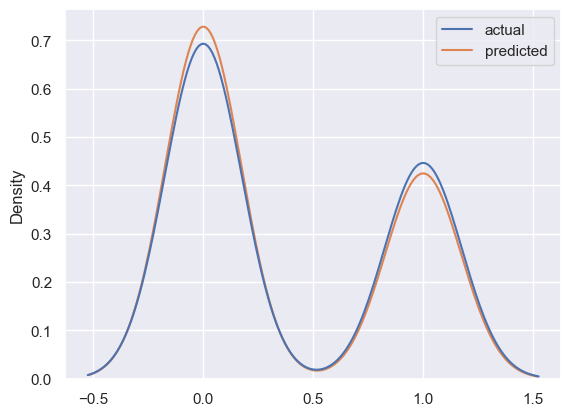

In [57]:
sns.kdeplot(pd.DataFrame({'actual': y_test, 'predicted': lr_pred}));

#### 2. Support Vector Machines

In [58]:
feature_imp(norm_dist, y_train, svc)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       104
           1       1.00      0.96      0.98        67

    accuracy                           0.98       171
   macro avg       0.99      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



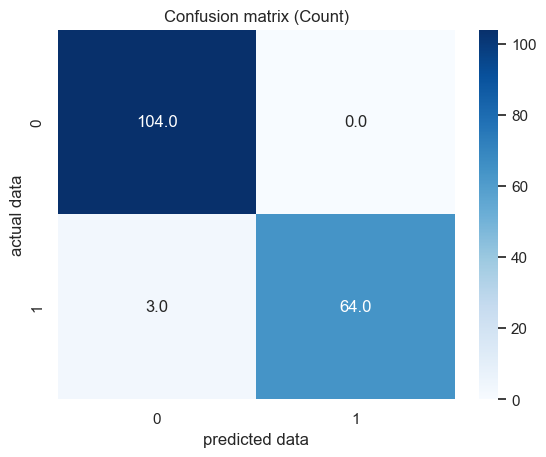

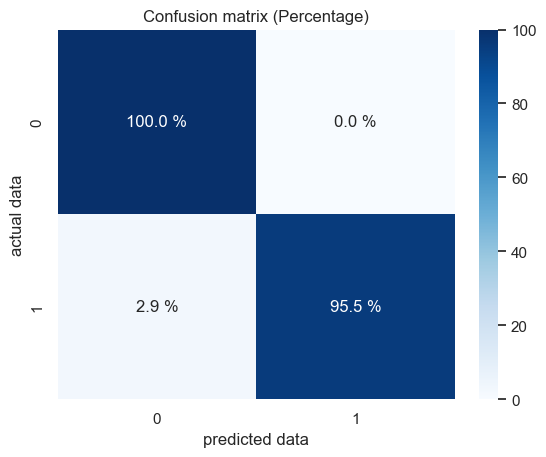

In [59]:
classification_rep(svc, norm_test, y_test, plot=True)

#### Observation:
* `LR and SVM models have the highest accuracy. However, for this problem, Recall is the most important metric and the SVM model has the highest recall.`


* `Since recall is very important we may want to check for other models which may not be as accurate as the SVM model but have a high recall on malignant cases.`

#### 3. XGBoost

In [60]:
feature_imp(norm_dist, y_train, xgb)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       104
           1       0.96      0.97      0.96        67

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



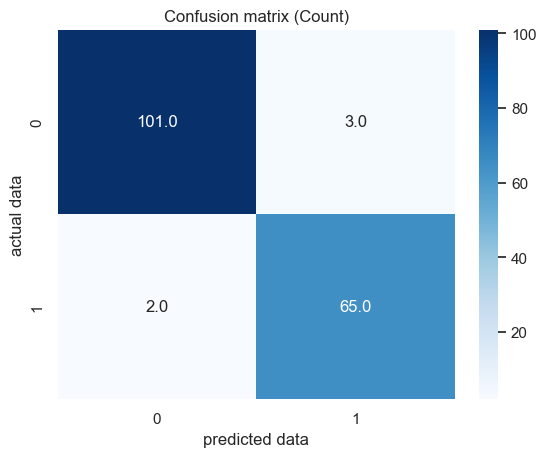

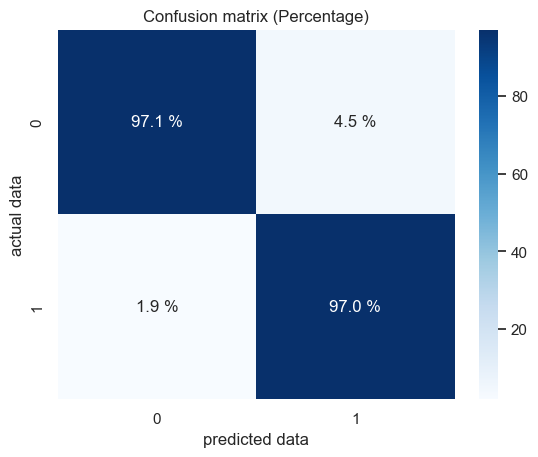

In [61]:
xgb_pred = classification_rep(xgb, norm_test, y_test, plot=True, return_=True)

#### Observation:
* `The SVC model has a 100% precision on malignant cases (all malignant cells/cases predicted are actually malignant) and also a 100% recall on benign cases (all benign cases were correctly predicted), however, the model misclassifies some malignant cells as benign. This is a very critical issue in the health industry. As shown above, the XGBoost model does not have a 100% precision but it has a higher recall than the SVM model.`

### Next:
* `Let's check the model's performance on the training data`

In [62]:
classification_rep(xgb, norm_dist, y_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       253
           1       1.00      1.00      1.00       145

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398



#### Observation:
* `We can see the model gets 100% accuracy on the training data.`

* `NEXT let's attempt to generalize the model`

### Model Tuning

* `Since our XGBClassifier model overfits, let's try and increase the regularizations`

In [63]:
xgb_tune = XGBClassifier(reg_alpha=1)
train_models(norm_dist, norm_test, y_train, y_test, [xgb_tune])

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
accuracy on train data: 0.9974874371859297
accuracy on test data: 0.9590643274853801
f1 score: 0.9473684210526316
matthews coef score: 0.9139478687299023



In [64]:
xgb_tune = XGBClassifier(reg_alpha=2)  # default L2 parameter is 1
train_models(norm_dist, norm_test, y_train, y_test, [xgb_tune])

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
accuracy on train data: 0.9949748743718593
accuracy on test data: 0.9473684210526315
f1 score: 0.931297709923664
matthews coef score: 0.889292374786322



#### Observation:

* `We see that using regularisation reduces training accuracy but it also reduces the test accuracy`

#### Next:
* `Let's use gridsearchcv to check for the optimal regularisation parameters as well as other important parameters`

### Paremeter selection

In [65]:
# Define the parameters to search
param_grid = {
    'max_depth': [5, 6],  # default is 6 link to documentation below
    'reg_alpha': [0, 1],  # default is 0
    'reg_lambda': [1, 2, 10],  # default is 1
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200],  # default is 100
    'random_state': [random_state]
}

# Initialize XGBClassifier and GridSearchCV
xgb_tune = XGBClassifier()
grid_search = GridSearchCV(xgb_tune, param_grid, cv=5, scoring='f1')

# Fit the grid search to the train data
grid_search.fit(norm_dist, y_train)

# evaluate the model on the test data
best_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)
print("Best mean score:", grid_search.best_score_)
print("Test accuracy:", best_model.score(norm_test, y_test))

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'random_state': 2, 'reg_alpha': 0, 'reg_lambda': 2}
Best mean score: 0.968154948499776
Test accuracy: 0.9707602339181286


Here's a link to the [documentation](https://xgboost.readthedocs.io/en/stable/parameter.html).


In [66]:
train_models(norm_dist, norm_test, y_train, y_test, [best_model])

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=2, ...)
accuracy on train data: 1.0
accuracy on test data: 0.9707602339181286
f1 score: 0.962962962962963
matthews coef score: 0.9388808720248912



#### Observation:
* `We see that the gridsearch model has the same test and train accuracies with the default xgb model`

### Model comparison
Let's compare model performance using box plots

In [67]:
scores_list = []

models_ = [best_model, xgb, rfc, lr, svc]
for i, model_ in enumerate(models_):
    if (model_ == best_model) or (model_ ==xgb):
        print(f"XGBClassifier {i+1}")
    else: print(model_)
    temp_list = []
    k_folds = KFold(n_splits = 10)

    scores = cross_val_score(model_, norm_dist, y_train, cv = k_folds)
    print("Scores: ", list(scores))
    print("Average CV Score: ", scores.mean(), '\n')
    scores_list.append(scores)

XGBClassifier 1
Scores:  [0.875, 1.0, 0.975, 1.0, 1.0, 1.0, 0.95, 0.975, 0.9230769230769231, 1.0]
Average CV Score:  0.9698076923076924 

XGBClassifier 2
Scores:  [0.875, 0.975, 0.975, 1.0, 1.0, 0.975, 0.95, 0.975, 0.9230769230769231, 1.0]
Average CV Score:  0.9648076923076923 

RandomForestClassifier(random_state=2)
Scores:  [0.875, 1.0, 0.975, 1.0, 0.95, 1.0, 0.95, 0.95, 0.8974358974358975, 0.9743589743589743]
Average CV Score:  0.9571794871794872 

LogisticRegression(random_state=2)
Scores:  [0.95, 0.925, 1.0, 1.0, 1.0, 1.0, 0.975, 1.0, 1.0, 0.9487179487179487]
Average CV Score:  0.9798717948717949 

SVC(kernel='linear')
Scores:  [0.95, 0.95, 0.975, 1.0, 0.975, 0.975, 0.95, 1.0, 1.0, 0.9743589743589743]
Average CV Score:  0.9749358974358975 



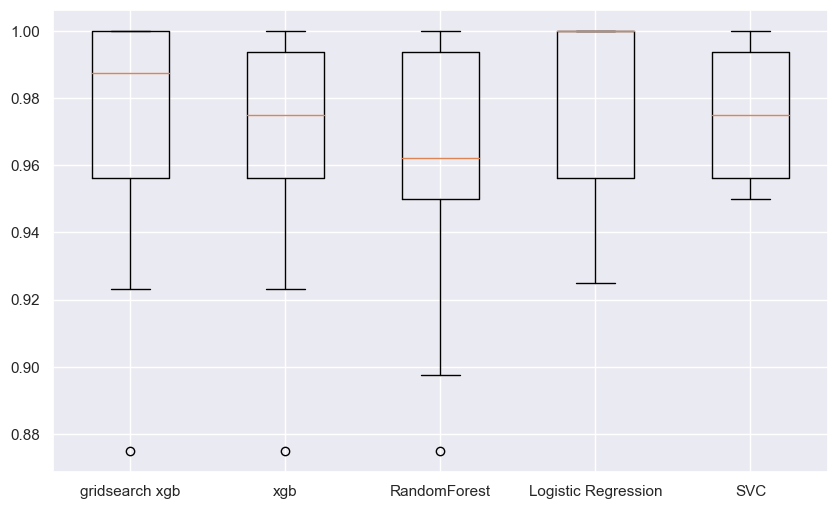

In [68]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(scores_list)
ax.set_xticklabels(['gridsearch xgb', 'xgb', 'RandomForest', 'Logistic Regression', 'SVC'])
plt.show()

#### Observation:

* `LR and SVM are the best performing models`

## Neural Network

In [69]:
# get a validation set
norm_d, norm_val, y_t, y_val = train_test_split(norm_dist, y_train, test_size=0.2, random_state=random_state)

### Training and hypertuning

`First, let us create a simple neural network and check it's performance`

`Ignore warnings below`

In [70]:
# We remove penalizations as we do not expect simple model to overfit.
# This model has an input dense layer of size 8 and a hidden layer of size 16 with no dropouts and regularizations
# Callback clause is inplace with patience set to 3
_, model2 = nn_compile(blocks=[16], regu=0, first=8, verbose=1)

Epoch 1/150
318/318 [==============================] - 1s 2ms/step - loss: 0.4121 - accuracy: 0.8616 - val_loss: 0.1877 - val_accuracy: 0.9625
Epoch 2/150
318/318 [==============================] - 0s 1ms/step - loss: 0.1413 - accuracy: 0.9654 - val_loss: 0.1098 - val_accuracy: 0.9750
Epoch 3/150
318/318 [==============================] - 0s 1ms/step - loss: 0.0955 - accuracy: 0.9811 - val_loss: 0.0861 - val_accuracy: 0.9750
Epoch 4/150
318/318 [==============================] - 0s 1ms/step - loss: 0.0752 - accuracy: 0.9874 - val_loss: 0.0755 - val_accuracy: 0.9750
Epoch 5/150
318/318 [==============================] - 0s 1ms/step - loss: 0.0622 - accuracy: 0.9843 - val_loss: 0.0760 - val_accuracy: 0.9625
Epoch 6/150
318/318 [==============================] - 0s 1ms/step - loss: 0.0536 - accuracy: 0.9874 - val_loss: 0.0688 - val_accuracy: 0.9625
Epoch 7/150
318/318 [==============================] - 0s 1ms/step - loss: 0.0458 - accuracy: 0.9874 - val_loss: 0.0701 - val_accuracy: 0.9500

In [71]:
# evaluate the model
nn_evaluation(model2)

Training accuracy
f1 score: 0.9915966386554621
matthews coef score: 0.9866610360199697

Validation accuracy
f1 score: 0.9411764705882353
matthews coef score: 0.9140476111686061

Test accuracy
f1 score: 0.9552238805970149
matthews coef score: 0.926377726750861



In [72]:
# We remove regularizations as we do not expect simple model to overfit.
# This model has an input dense layer of size 12 and a hidden layer of size 12 with no dropouts and regularizations
# Callback clause is inplace with patience set to 3
_, model2__ = nn_compile(blocks=[12], regu=0, first=12)
nn_evaluation(model2__)

Training accuracy
f1 score: 0.9874476987447698
matthews coef score: 0.9799132491989601

Validation accuracy
f1 score: 0.92
matthews coef score: 0.8836363636363637

Test accuracy
f1 score: 0.9473684210526316
matthews coef score: 0.9139478687299023



`Now let's create a more robust neural network model and compare performance`

In [73]:
# we include dropouts as this model is expected to overfit
# This model has an input dense layer of size 32 and 2 hidden layers of size 64 and 32
# with dropouts and regularizations on each hidden layer
# Callback clause is inplace with patience set to 10 and batch size increased to 2
_, model2_ = nn_compile(blocks=[64, 32], dropout=0.3, batch_size=2, patience=10, verbose=1)

Epoch 1/150
159/159 [==============================] - 2s 2ms/step - loss: 0.9638 - accuracy: 0.8994 - val_loss: 0.6540 - val_accuracy: 0.9625
Epoch 2/150
159/159 [==============================] - 0s 2ms/step - loss: 0.5654 - accuracy: 0.9654 - val_loss: 0.4548 - val_accuracy: 0.9875
Epoch 3/150
159/159 [==============================] - 0s 2ms/step - loss: 0.4088 - accuracy: 0.9780 - val_loss: 0.3451 - val_accuracy: 0.9875
Epoch 4/150
159/159 [==============================] - 0s 2ms/step - loss: 0.2967 - accuracy: 0.9811 - val_loss: 0.2907 - val_accuracy: 0.9500
Epoch 5/150
159/159 [==============================] - 0s 2ms/step - loss: 0.2242 - accuracy: 0.9843 - val_loss: 0.2214 - val_accuracy: 0.9625
Epoch 6/150
159/159 [==============================] - 0s 2ms/step - loss: 0.1851 - accuracy: 0.9874 - val_loss: 0.2093 - val_accuracy: 0.9625
Epoch 7/150
159/159 [==============================] - 0s 2ms/step - loss: 0.1534 - accuracy: 0.9874 - val_loss: 0.1894 - val_accuracy: 0.9500

In [74]:
nn_evaluation(model2_)

Training accuracy
f1 score: 1.0
matthews coef score: 1.0

Validation accuracy
f1 score: 0.9615384615384615
matthews coef score: 0.9445929770307909

Test accuracy
f1 score: 0.9558823529411764
matthews coef score: 0.9270428504935793



`Now let us see the how the confusion matrix compares with the best existing model (XGB) on the test data`

##### a. XGB confustion matrix

In [75]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       104
           1       0.96      0.97      0.96        67

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



##### b. NN confusion matrix

In [76]:
test_pred2 = model2_.predict(norm_test, verbose=0)
# convert predictions by rounding them up. This method indicates that 0.5 is the threshold
test_pred = [round(predictions[0]) for predictions in test_pred2]
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       104
           1       0.94      0.97      0.96        67

    accuracy                           0.96       171
   macro avg       0.96      0.97      0.96       171
weighted avg       0.97      0.96      0.96       171



#### Observation:
* `Both models have same recall on malignant cases however, the XGB model has a better accuracy overall.`
* `The current threshold for distinguishing predictions is 0.5. We may look to reduce or increase this threshold in hopes that we get more correct malignant cases.`

* `To validate this idea, let us check the wrong predictions and see the model's confidence in the wrong predictions.`

In [79]:
print('These are the incorrect predictions')
for i in range(len(test_pred)):
    if test_pred[i] != y_test.values[i]:
        confidence = round(float(test_pred2[i]) * 100, 2)
        if test_pred[i] == 0:
            confidence = round(100 - confidence, 2)
        print(f"Wrong prediction: {test_pred[i]}: Confidence: {confidence}%")

These are the incorrect predictions
Wrong prediction: 1: Confidence: 86.39%
Wrong prediction: 0: Confidence: 86.46%
Wrong prediction: 1: Confidence: 99.47%
Wrong prediction: 0: Confidence: 99.64%
Wrong prediction: 1: Confidence: 56.25%
Wrong prediction: 1: Confidence: 99.68%


#### Observation:
`We can see that the model seems to be very sure about these wrong predictions so adjusting the threshold might flaw the model`

#### Next:
`Let's use sparse categorical crossentropy as the loss and compare performance`

In [80]:
# This model has an input dense layer of size 32 and a hidden layer of size 512 
# with no dropout but a regularization on the hidden layer
# Callback clause is inplace with patience set to 10 and batch size increased to 2
_, model3 = nn_compile(first=512, regu=0, epochs=50, final=2, # first=8,
                        loss='sparse_categorical_crossentropy', verbose=1)

Epoch 1/50
318/318 [==============================] - 1s 2ms/step - loss: 0.1524 - accuracy: 0.9528 - val_loss: 0.0811 - val_accuracy: 0.9750
Epoch 2/50
318/318 [==============================] - 0s 1ms/step - loss: 0.0571 - accuracy: 0.9843 - val_loss: 0.0983 - val_accuracy: 0.9375
Epoch 3/50
318/318 [==============================] - 0s 1ms/step - loss: 0.0457 - accuracy: 0.9874 - val_loss: 0.0484 - val_accuracy: 0.9750
Epoch 4/50
318/318 [==============================] - 0s 1ms/step - loss: 0.0344 - accuracy: 0.9811 - val_loss: 0.0413 - val_accuracy: 0.9875
Epoch 5/50
318/318 [==============================] - 0s 1ms/step - loss: 0.0176 - accuracy: 0.9937 - val_loss: 0.1073 - val_accuracy: 0.9500
Epoch 6/50
318/318 [==============================] - 0s 1ms/step - loss: 0.0121 - accuracy: 0.9969 - val_loss: 0.0851 - val_accuracy: 0.9375
Epoch 7/50
318/318 [==============================] - 1s 2ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.1226 - val_accuracy: 0.9500


In [81]:
nn_evaluation(model3, sparse=True)

Training accuracy
f1 score: 1.0
matthews coef score: 1.0

Validation accuracy
f1 score: 0.92
matthews coef score: 0.8836363636363637

Test accuracy
f1 score: 0.9465648854961832
matthews coef score: 0.9140472170602045



In [82]:
_, model3_ = nn_compile(blocks=[128, 32], dropout=0.2, regu=0.05, epochs=100, final=2, 
                        loss='sparse_categorical_crossentropy', batch_size=10, verbose=1)

Epoch 1/100
32/32 [==============================] - 1s 7ms/step - loss: 4.7148 - accuracy: 0.8459 - val_loss: 3.7298 - val_accuracy: 0.9500
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 3.0812 - accuracy: 0.9371 - val_loss: 2.4432 - val_accuracy: 0.9625
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 2.0288 - accuracy: 0.9528 - val_loss: 1.5931 - val_accuracy: 0.9625
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 1.3247 - accuracy: 0.9623 - val_loss: 1.0521 - val_accuracy: 0.9625
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.8755 - accuracy: 0.9748 - val_loss: 0.7063 - val_accuracy: 0.9625
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6097 - accuracy: 0.9717 - val_loss: 0.4902 - val_accuracy: 0.9750
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.4287 - accuracy: 0.9748 - val_loss: 0.3630 - val_accuracy: 0.9750
Epoch 8/100
3

In [83]:
nn_evaluation(model3_, sparse=True)

Training accuracy
f1 score: 0.9915966386554621
matthews coef score: 0.9866610360199697

Validation accuracy
f1 score: 0.9803921568627451
matthews coef score: 0.9716254134469435

Test accuracy
f1 score: 0.9624060150375939
matthews coef score: 0.9385558179588132



In [84]:
test_pred2 = model3_.predict(norm_test, verbose=0)
# convert predictions by rounding them up. This method checks for the maximum confidence
test_pred = prd(test_pred2)
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       104
           1       0.97      0.96      0.96        67

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



`Let's check for model's confidence in wrong predictions`

In [85]:
for i in range(len(test_pred)):
    if test_pred[i] != y_test.values[i]:
#         if test_pred[i] == 1:
#             confidence = test_pred2
        confidence = round(max(test_pred2[i]) * 100, 2)
        print(f"Wrong prediction: {test_pred[i]}; Confidence: {confidence}%")

Wrong prediction: 0; Confidence: 78.24%
Wrong prediction: 1; Confidence: 60.85%
Wrong prediction: 0; Confidence: 72.5%
Wrong prediction: 0; Confidence: 45.04%
Wrong prediction: 1; Confidence: 46.82%


`We see that the model's confidence in misclassificaiton of malignant cases (incorrectly classifying 1 as 0)  is less than 73%.`

`In a bid to get about higher recall on malignant cases which is the most desirable solution for this problem, we may decide to classify every benign (0) predicition below 73% as malignant (1). This is likely to affect the model's precision and recall on benign cases.`

### Modifying threshold

              precision    recall  f1-score   support

           0       0.99      0.87      0.92       104
           1       0.82      0.99      0.90        67

    accuracy                           0.91       171
   macro avg       0.91      0.93      0.91       171
weighted avg       0.92      0.91      0.91       171



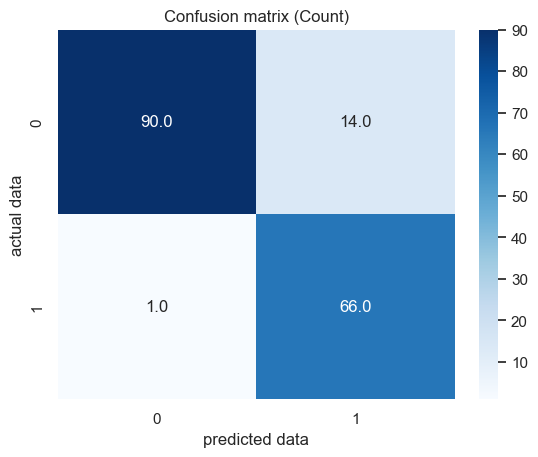

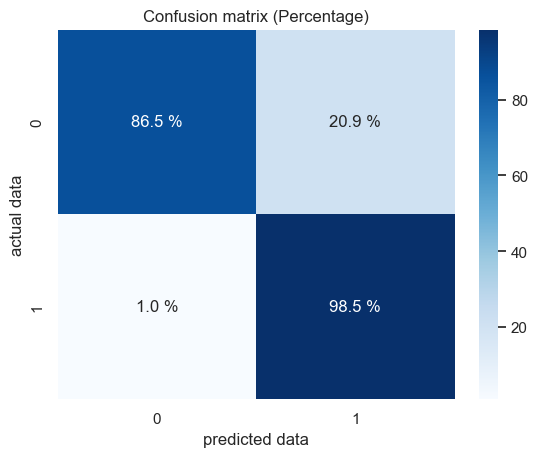

In [87]:
# convert predictions this time using a 0.726 threshold rather than checking for the maximum confidence
test_pred_ = prd2(test_pred2, 0.726)
print(classification_report(y_test, test_pred_))
confusion_plot(y_test, test_pred_)

#### Observation:
* `We are able to achieve the highest recall on malignant cases using the 73% threshold. However, the model's precision reduces significantly meaning the model's decisions may not be fully trusted.`

#### Next
* `Let's view the change in accuracies between using the default threshold, and the modified threshold`

#### Change in accuracies

In [88]:
print(f"Default Threshold:\n{classification_report(y_test, test_pred)}\
\nModified Threshold:\n{classification_report(y_test, test_pred_)}")


50% Threshold:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       104
           1       0.97      0.96      0.96        67

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171

73% Threshold:
              precision    recall  f1-score   support

           0       0.99      0.87      0.92       104
           1       0.82      0.99      0.90        67

    accuracy                           0.91       171
   macro avg       0.91      0.93      0.91       171
weighted avg       0.92      0.91      0.91       171



####  Observation:
##### Change in precision
* `The average precision drops from 97% (when using maximum confidence threshold), to 90% (when using 73% threshold).`

* `We can see the precision on malignant cases is reduced from 97% to 82%`

##### Change in Recall
* `We see the model's mean recall decline from 97% to 93%`

* `However, we can see the model (with the modified threshold) achieves the highest ever recall on malignant cases (99%). The previous highest being the xgb model with 97% recall on malignant cases.`

## Trade-off
We can see that the neural network model with the modified threshold has a low precision score particularly for malignant cases meaning the model classifies some benign cases as malignant. This raises questions about trusting the model's decisions. Asking questions like "is this cell truly malignant?". However, the model has a very high recall in malignant cases meaning that this model only misclassifies 0.01% of malignant cells as benign.

In [89]:
# store the training history of the model
history_2 = _

##### Now let's plot the training history

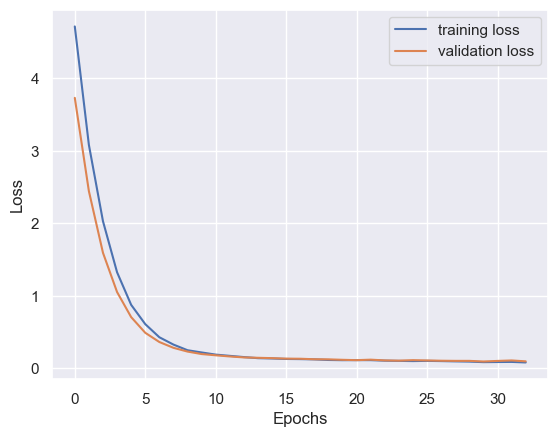

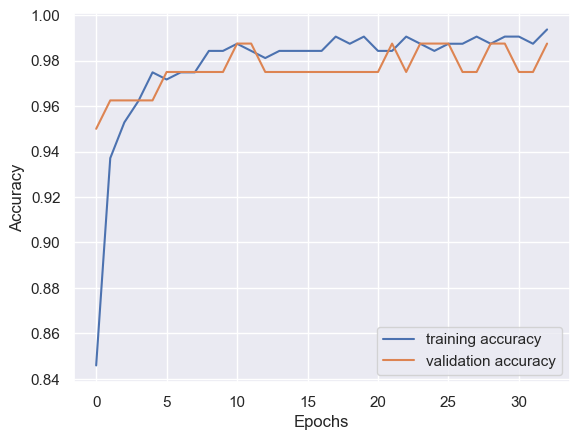

In [93]:
fig, ax = plt.subplots()
ax.plot(history_2['loss'])
ax.plot(history_2['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training loss', 'validation loss'])
plt.show()
plt.plot(history_2['accuracy'])
plt.plot(history_2['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()

## Summary

1. `Multiple datasets were prepared and tested with 4 machine learning algorithms. The dataset which had the highest accuracy is the dataset in which skewness was removed.`<p></p>
2. `The model with the highest test accuracy is the Support Vector Machine model and this model did not overfit. However, the only problem with this model is the recall on malignant cases which was 95.5% but it wasn't the highest.`<p></p>
3. `The statistical machine learning model with the highest recall on malignant cases is the XGBoost model 97% recall on malignant cases.`<p></p>
4. `The neural network model had a similar recall accuracy as the XGBoost model, however, the XGBoost model had a better performance all-round.`<p></p>
5. `The neural network model, after modifying the classification threshold (from selecting maximum confidence score, to using a threshold of 73%)had the highest recall on malignant cases with a staggering 99%.`<p></p>
6. `Trade-off: There is a trade-off between having a model in which its decisions are trusted (precision) and having a model in which you trust to identify all malignant cases (recall).`<p></p>
7. `The best trustable model with high recall (high precision and high recall) and low computation time/power is the XGBoost model.`<p></p>
8. `The best model with the highest recall (99%) is the neural network model with modified threshold.`

## References
1. UCI (2023) Breast Cancer Wisconsin (Diagnostic) Data Set. Available: https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)
2. StackAbuse (2023) Principal Component Analysis (PCA) in Python with Scikit-learn. Available: https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/